# Research Question 3

**Can we classify whether a given week’s sales (across all Walmart stores) will be above or below the average using only general predictors like fuel price, CPI, unemployment, and holiday flags?**

**Hypothesis:**  
Weekly sales can be reliably categorized as “high” or “low” using classification models with predictors such as fuel price, CPI, unemployment, and holiday flags.

## Introduction

### Objective

This notebook aims to determine whether general economic and temporal factors can predict if weekly sales are above or below average across Walmart stores. Store-specific identifiers are excluded to avoid models that memorize individual store patterns, focusing instead on generalizable insights.

### Approach

Exploratory analysis in the DataWrangling notebook showed very little linear correlation between most features and weekly sales, suggesting that linear models may struggle to capture meaningful relationships. However, classification models—particularly tree-based methods—are well-suited to detect nonlinear patterns, motivating their use here.

To improve model performance, features such as year, month, and week are extracted from the date column. Scaling techniques—including StandardScaler for normally distributed features and MinMaxScaler for others—are applied to normalize the data. Several classification algorithms are trained and evaluated, including Decision Tree, Random Forest, and Gaussian Naive Bayes, to identify the most effective approach.

### Note

While classification is not typically used for continuous targets like sales, reframing the problem as a binary classification simplifies interpretation and allows assessment of the predictive power of general features without relying on store-specific data.

## Data Ingestion

In this section, we load the Walmart Sales dataset and perform initial exploration to understand its structure and contents. We check for missing values, duplicates, and get a summary of the data to ensure it is ready for further processing.

In [8628]:
import pandas as pd
import numpy as np

# matplotlib.pyplot for data plots
import matplotlib.pyplot as plt

import seaborn as sns

In [8629]:
# Load dataset
df = pd.read_csv('../Data/Walmart_Sales.csv')

In [8630]:
# Check the column names
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [8631]:
# Check the shape
df.shape

(6435, 8)

In [8632]:
# Get summary statistics for numerical columns
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [8633]:
# Check for missing values in each column
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [8634]:
# Check for duplicate rows
df.duplicated().sum()

0

In [8635]:
# Display a random sample of 5 rows
df.sample(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
4584,33,02-04-2010,274634.52,0,66.79,3.086,126.603484,9.849
396,3,16-03-2012,411775.80,0,64.00,3.734,224.716695,6.833
2112,15,16-03-2012,570611.23,0,47.42,4.021,137.584387,7.943
951,7,18-11-2011,539826.56,0,29.53,3.479,195.718471,8.513
631,5,25-03-2011,294732.50,0,70.71,3.473,215.164087,6.634


## Data Cleaning

In this section, we prepare the dataset for analysis by removing unnecessary columns, converting data types, and addressing potential outliers. These steps help ensure data quality and improve the reliability of later modeling.

In [8636]:
# Drop the 'Store' column to avoid store-specific memorization
df.drop(['Store'], axis=1, inplace=True)

In [8637]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

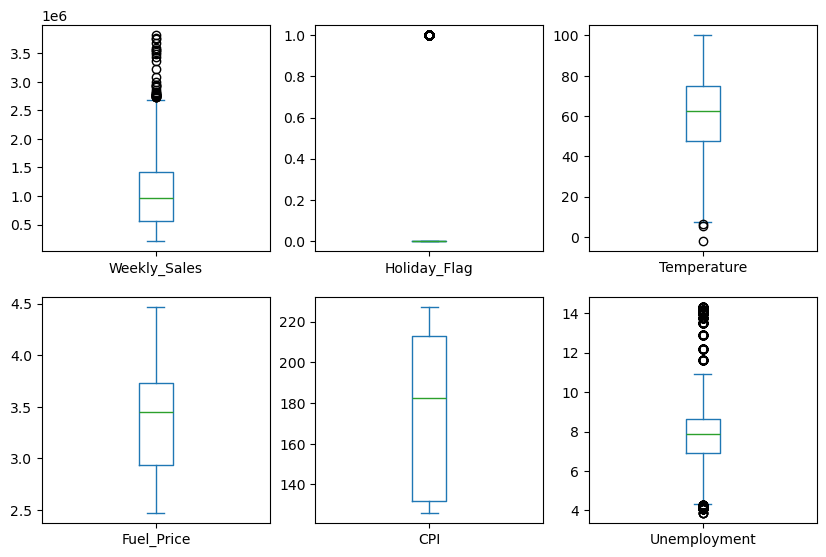

In [8638]:
# Visualize distributions and potential outliers with box-and-whisker plots
df.plot(kind='box', subplots=True, layout=(3, 3), figsize=(10, 10), sharex=False, sharey=False)
plt.show()

In [8639]:
# Function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    non_outlier_mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
    outliers = df[~non_outlier_mask]
    df_clean = df[non_outlier_mask]

    print(f"Number of outliers to be removed from '{column}': {len(outliers)}")
    print(f"Remaining rows: {len(df_clean)}")

    return df_clean

In [8640]:
# Remove outliers from selected columns
df = remove_outliers(df, 'Weekly_Sales')
df = remove_outliers(df, 'Temperature')
df = remove_outliers(df, 'Unemployment')

Number of outliers to be removed from 'Weekly_Sales': 34
Remaining rows: 6401
Number of outliers to be removed from 'Temperature': 3
Remaining rows: 6398
Number of outliers to be removed from 'Unemployment': 481
Remaining rows: 5917


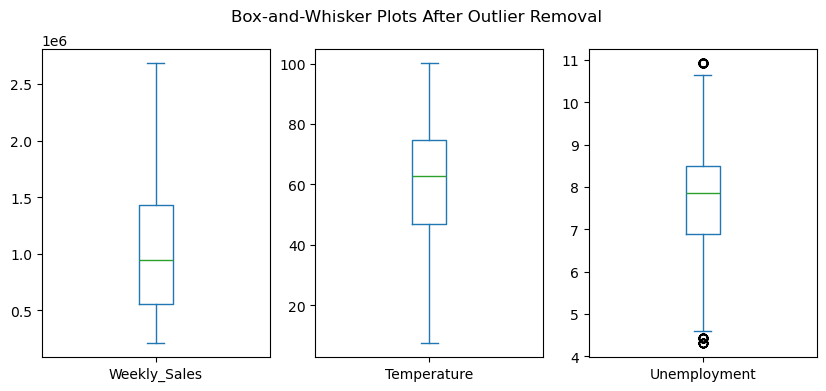

In [8641]:
# Visualize the same columns again after outlier removal
df[['Weekly_Sales', 'Temperature', 'Unemployment']].plot(kind='box', subplots=True, layout=(1, 3), figsize=(10, 4), sharex=False, sharey=False)
plt.suptitle('Box-and-Whisker Plots After Outlier Removal')
plt.show()

In [8642]:
# Preview cleaned data
df.sample(5)

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
1724,2010-04-02,2142482.14,0,42.15,2.842,126.603484,8.107
4419,2012-07-27,1303732.36,0,88.09,3.407,221.578546,6.565
1342,2011-02-25,1967996.71,0,53.59,3.398,128.130000,8.744
4259,2012-03-30,449603.91,0,67.87,3.845,220.999125,7.057
515,2011-09-30,1929486.63,0,72.15,3.371,129.606067,5.644


## Feature Engineering

In this section, we create new features from existing data to improve model performance. This includes extracting temporal features from the date column and generating a binary target variable for classification. Scaling is handled in the next section.

**Note:** We also experimented with extracting a "Season" feature from the date, but it did not improve model performance and had zero feature importance, so it was removed from the final feature set.

In [8643]:
# Extract year, month, quarter, and week from the 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Week'] = df['Date'].dt.isocalendar().week

# Drop the original 'Date' column as its information is now captured in new features
df.drop(['Date'], axis=1, inplace=True)

In [8644]:
# Create a binary target: 1 if weekly sales are above the average, else 0
mean_sales = df['Weekly_Sales'].mean()
df['High_Sales'] = (df['Weekly_Sales'] > mean_sales).astype(int)

# Drop 'Weekly_Sales' since it's now represented in the target
df.drop(['Weekly_Sales'], axis=1, inplace=True)

In [8645]:
# Preview the engineered features
df.head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Quarter,Week,High_Sales
0,0,42.31,2.572,211.096358,8.106,2010,2,1,5,1
1,1,38.51,2.548,211.242170,8.106,2010,2,1,6,1
2,0,39.93,2.514,211.289143,8.106,2010,2,1,7,1
3,0,46.63,2.561,211.319643,8.106,2010,2,1,8,1
4,0,46.50,2.625,211.350143,8.106,2010,3,1,9,1


## Feature Selection & Scaling

In this section, we analyze feature relationships and prepare the data for modeling. We first examine the correlation matrix to check for strong linear relationships or redundancy among features. Next, we use histograms to visually assess the distribution of each feature, which guides our choice of scaling method.

We begin by visualizing the correlation matrix to check for any strong linear relationships between features and the target variable. This helps identify redundant or irrelevant features.

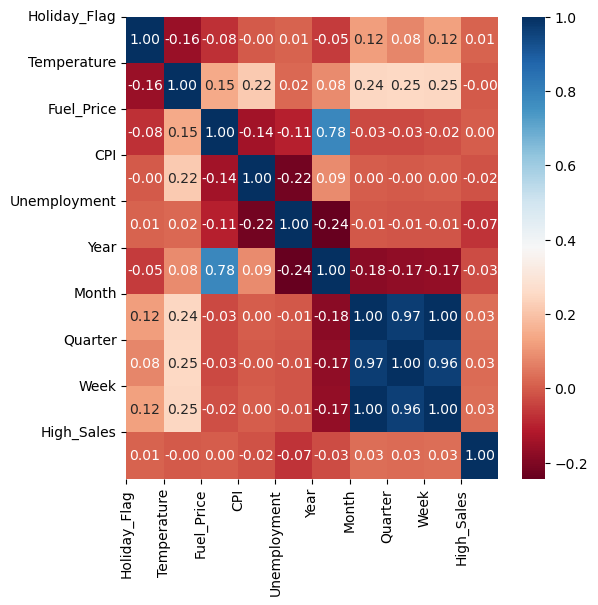

In [8646]:
# Compute and plot the correlation matrix
corr = df.corr()
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

As observed, most features show very little linear correlation with the target, so no features are removed at this stage.

**Note on Unemployment and Sales Correlation**

The correlation matrix shows a very weak negative correlation (-0.07) between unemployment and high sales weeks. This suggests a slight tendency for higher unemployment to be associated with lower sales, but the relationship is too weak to be meaningful. While this aligns with the intuition that higher unemployment might reduce consumer spending, the data does not provide strong evidence for this effect. 

Next, we plot histograms of the features. This allows us to visually determine which features are approximately normally distributed and which are not. These observations inform our choice of scaler for each feature.

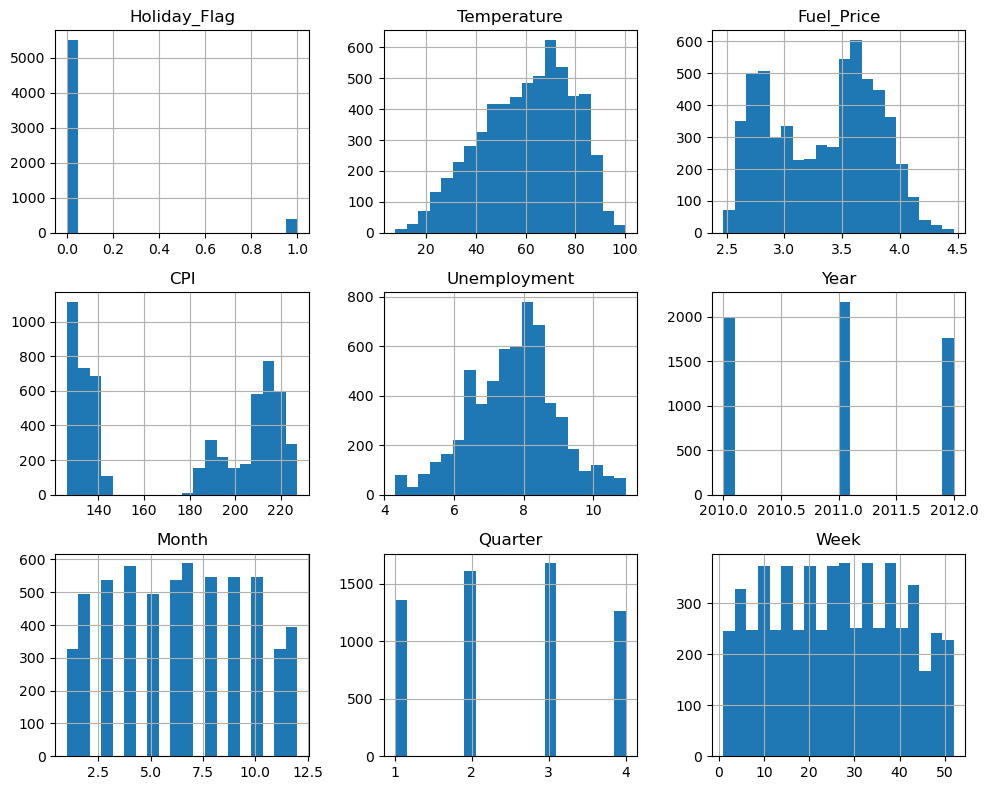

In [8647]:
# Plot histograms for features only (excluding the target)
feature_columns = [col for col in df.columns if col != 'High_Sales']
df[feature_columns].hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

Based on the histograms, StandardScaler is applied to features that are roughly normally distributed, while MinMaxScaler is used for features that are not. This ensures that all features are on comparable scales.

In [8648]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Get the original feature order (excluding the target)
original_feature_order = [col for col in df.columns if col != 'High_Sales']

# Features identified as approximately normal
features_norm = ['Temperature', 'Unemployment']
# All other features
features_non_norm = [col for col in df.columns if col not in features_norm + ['High_Sales']]

# Apply StandardScaler to normal features
standardScaler = StandardScaler()
X_norm = standardScaler.fit_transform(df[features_norm])
X_norm = pd.DataFrame(X_norm, columns=features_norm)

# Apply MinMaxScaler to non-normal features
scaler = MinMaxScaler()
X_non_norm = scaler.fit_transform(df[features_non_norm])
X_non_norm = pd.DataFrame(X_non_norm, columns=features_non_norm)

# Concatenate and reorder columns to match original order
X = pd.concat([X_non_norm, X_norm], axis=1)

# Ensures column order matches original df (excluding target)
X = X[original_feature_order]
y = df['High_Sales']

In [8649]:
# Preview the scaled features
X.head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Quarter,Week
0,0.0,-0.985777,0.050100,0.840500,0.308627,0.0,0.090909,0.0,0.078431
1,1.0,-1.192468,0.038076,0.841941,0.308627,0.0,0.090909,0.0,0.098039
2,0.0,-1.115231,0.021042,0.842405,0.308627,0.0,0.090909,0.0,0.117647
3,0.0,-0.750801,0.044589,0.842707,0.308627,0.0,0.090909,0.0,0.137255
4,0.0,-0.757872,0.076653,0.843008,0.308627,0.0,0.181818,0.0,0.156863


We plot the histograms again after scaling to confirm that all features are now on comparable ranges and ready for modeling.

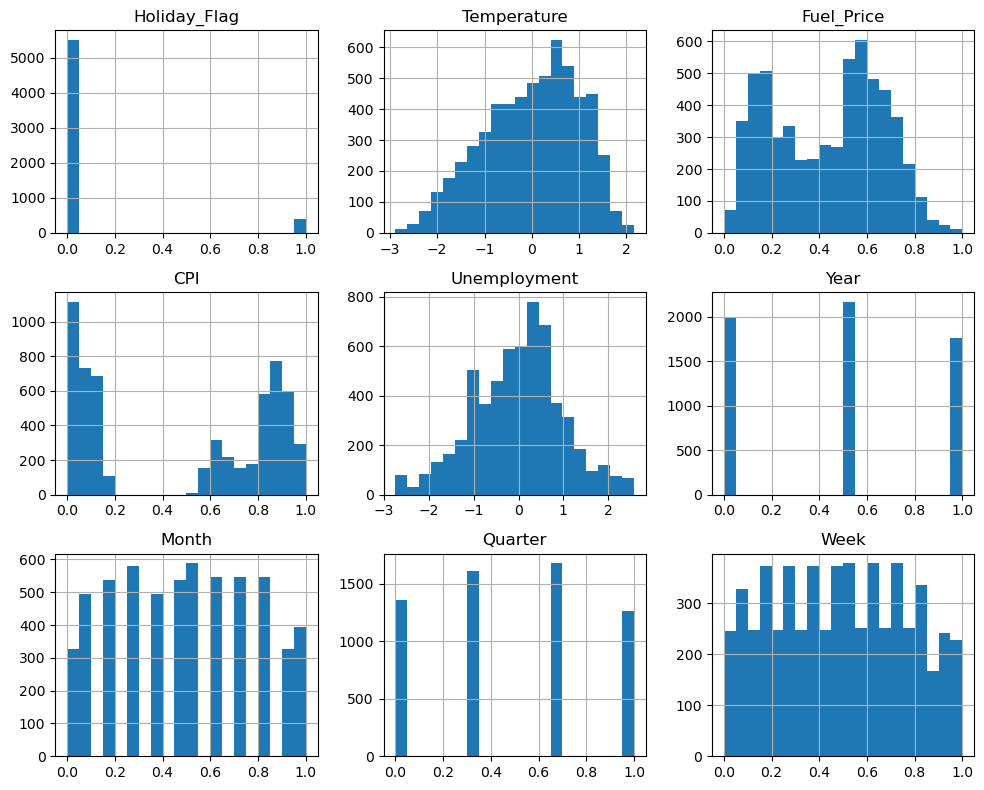

In [8650]:
X.hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

## Model Training & Evaluation

In this section, we train and evaluate several classification models to determine which performs best at predicting whether weekly sales are above or below average. We use Decision Tree, Random Forest, and Gaussian Naive Bayes classifiers. Model performance is assessed using accuracy, classification reports, confusion matrices, ROC curves, and cross-validation.

We begin by splitting the data into training and test sets. A test size of 20% was found to provide a good balance between training and evaluation.

In [8651]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (4733, 9)
Shape of X_test: (1184, 9)
Shape of y_train: (4733,)
Shape of y_test: (1184,)


### DecisionTreeClassifier

We first train a Decision Tree classifier. Through experimentation, a maximum depth of 10–12 was found to yield the best results. We evaluate the model using accuracy, classification report, confusion matrix, ROC curve, cross-validation, feature importance, and train/test accuracy.

In [8652]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

decisionTreeClassifier = DecisionTreeClassifier(max_depth=10, random_state=42)
decisionTreeClassifier.fit(X_train, y_train)
y_pred = decisionTreeClassifier.predict(X_test)

# Accuracy and classification report
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print(classification_report(y_test, y_pred))

Accuracy: 65.88%
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       666
           1       0.60      0.67      0.63       518

    accuracy                           0.66      1184
   macro avg       0.66      0.66      0.66      1184
weighted avg       0.67      0.66      0.66      1184



The Decision Tree model achieves an overall accuracy of 66%. Precision is higher for low sales weeks (class 0, precision: 0.72) than for high sales weeks (class 1, precision: 0.60). Recall is slightly higher for high sales weeks (0.67) than for low sales weeks (0.65). The F1-scores are 0.68 for low sales and 0.63 for high sales, indicating reasonably balanced performance. Overall, the model is somewhat better at correctly identifying low sales weeks, but still captures a substantial portion of high sales weeks as well.

#### Confusion Matrix

The confusion matrix summarizes the model’s classification performance by showing the counts of true positives, false positives, true negatives, and false negatives.

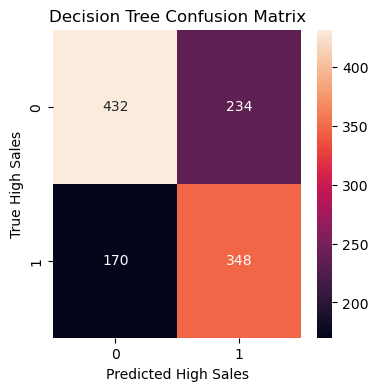

In [8653]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted High Sales")
plt.ylabel("True High Sales")
plt.title("Decision Tree Confusion Matrix")
plt.show()

The confusion matrix summarizes how well the classifier distinguishes between high and low sales weeks:

- **True Negatives (TN):** 432 weeks correctly predicted as low sales  
- **False Positives (FP):** 234 weeks incorrectly predicted as high sales  
- **False Negatives (FN):** 170 weeks incorrectly predicted as low sales  
- **True Positives (TP):** 348 weeks correctly predicted as high sales

This means the model is better at identifying weeks with low sales than weeks with high sales. The relatively high number of false positives and false negatives suggests there is still room for improving the model’s precision and recall for both classes.

#### ROC Curve

The ROC curve shows how well the model separates the two classes across different thresholds. The AUC score summarizes this performance; higher values mean better distinction between high and low sales weeks.

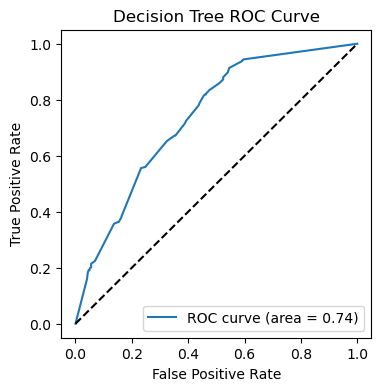

In [8654]:
# ROC curve
y_proba = decisionTreeClassifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend(loc="lower right")
plt.show()

The ROC curve visualizes the trade-off between the true positive rate (sensitivity) and the false positive rate.  
An area under the curve (AUC) of 0.74 indicates that the model has a reasonable ability to distinguish between high and low sales weeks, but is not highly accurate. A perfect model would have an AUC of 1.0, while a value of 0.5 would indicate random guessing.

#### Cross-Validation

To assess the robustness of the Decision Tree model, we perform 5-fold cross-validation on the entire dataset. This provides an estimate of how well the model generalizes to unseen data.

In [8655]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(decisionTreeClassifier, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy: {:.2f}%".format(cv_scores.mean() * 100))

Cross-validation scores: [0.14949324 0.15962838 0.3262891  0.28486898 0.24006762]
Mean CV accuracy: 23.21%


The cross-validation scores vary considerably across folds, ranging from about 15% to 33%, with a mean accuracy of 23.21%. This suggests that the model's performance is unstable and may not generalize well to new data, possibly due to class imbalance, data splits, or model limitations.

#### Feature Importance

The Decision Tree model provides feature importances, indicating which predictors most influence its classification decisions.

In [8656]:
importances = decisionTreeClassifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
4,Unemployment,0.430015
3,CPI,0.218265
1,Temperature,0.127657
5,Year,0.085201
8,Week,0.072145
2,Fuel_Price,0.051240
6,Month,0.005567
7,Quarter,0.005103
0,Holiday_Flag,0.004806


Unemployment is the most important feature for the Decision Tree, followed by CPI and Temperature. Features like Month, Quarter, and Holiday_Flag contribute very little to the model's decisions.

#### Train vs. Test Accuracy

Comparing train and test accuracy helps assess whether the model is overfitting or underfitting.

In [8657]:
train_acc = decisionTreeClassifier.score(X_train, y_train)
test_acc = decisionTreeClassifier.score(X_test, y_test)
print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Train Accuracy: 0.74
Test Accuracy: 0.66


The model achieves 74% accuracy on the training set and 66% accuracy on the test set. The moderate gap suggests some overfitting, but the model still generalizes reasonably well to unseen data.

### Random Forest Classifier

We now train a Random Forest classifier and evaluate its performance using accuracy, classification report, confusion matrix, ROC curve, cross-validation, feature importance, and train/test accuracy.

In [8658]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

randomForestClassifier = RandomForestClassifier(n_estimators=80, max_depth=8, random_state=42)
randomForestClassifier.fit(X_train, y_train)
y_pred_rf = randomForestClassifier.predict(X_test)

# Accuracy and classification report
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_rf) * 100))
print(classification_report(y_test, y_pred_rf))

Accuracy: 65.79%
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       666
           1       0.61      0.60      0.60       518

    accuracy                           0.66      1184
   macro avg       0.65      0.65      0.65      1184
weighted avg       0.66      0.66      0.66      1184



The Random Forest model achieves 66% accuracy. It performs slightly better at identifying low sales weeks (precision 0.69, recall 0.71) than high sales weeks (precision 0.61, recall 0.60), with balanced F1-scores for both classes.

#### Confusion Matrix

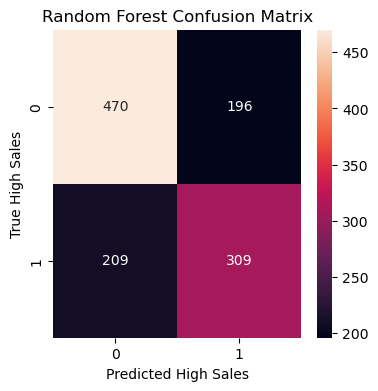

In [8659]:
# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_rf, annot=True, fmt='.0f')
plt.xlabel("Predicted High Sales")
plt.ylabel("True High Sales")
plt.title("Random Forest Confusion Matrix")
plt.show()

- True Negatives (TN): 470 weeks correctly predicted as low sales  
- False Positives (FP): 196 weeks incorrectly predicted as high sales  
- False Negatives (FN): 209 weeks incorrectly predicted as low sales  
- True Positives (TP): 309 weeks correctly predicted as high sales

The model is slightly better at identifying low sales weeks, but still captures a fair number of high sales weeks.

#### ROC Curve

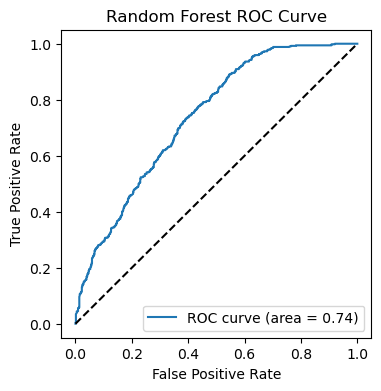

In [8660]:
# ROC curve
y_proba_rf = randomForestClassifier.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(4, 4))
plt.plot(fpr_rf, tpr_rf, label='ROC curve (area = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()

The Random Forest model achieves an AUC of 0.74, indicating a reasonable ability to distinguish between high and low sales weeks.

#### Cross-Validation

In [8661]:
from sklearn.model_selection import cross_val_score

cv_scores_rf = cross_val_score(randomForestClassifier, X, y, cv=5)
print("Cross-validation scores:", cv_scores_rf)
print("Mean CV accuracy: {:.2f}%".format(cv_scores_rf.mean() * 100))

Cross-validation scores: [0.24746622 0.14527027 0.42519019 0.37447168 0.18681319]
Mean CV accuracy: 27.58%


Cross-validation scores range from about 15% to 43%, with a mean accuracy of 27.58%. This variability suggests that model performance is unstable across different data splits.

#### Feature Importance

In [8662]:
importances_rf = randomForestClassifier.feature_importances_
feature_importance_rf_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

feature_importance_rf_df

,Feature,Importance
4,Unemployment,0.465840
3,CPI,0.158750
1,Temperature,0.140836
2,Fuel_Price,0.091984
8,Week,0.063959
5,Year,0.037893
6,Month,0.025595
7,Quarter,0.008210
0,Holiday_Flag,0.006933


Unemployment is the most important feature, followed by CPI and Temperature. Holiday_Flag and Quarter contribute very little to the model’s predictions.

#### Train vs. Test Accuracy

In [8663]:
train_acc_rf = randomForestClassifier.score(X_train, y_train)
test_acc_rf = randomForestClassifier.score(X_test, y_test)
print(f"Train Accuracy: {train_acc_rf:.2f}")
print(f"Test Accuracy: {test_acc_rf:.2f}")

Train Accuracy: 0.74
Test Accuracy: 0.66


The model achieves 74% accuracy on the training set and 66% on the test set, suggesting some overfitting but reasonable generalization to new data.

### Gaussian Naive Bayes Classifier

We now evaluate the Gaussian Naive Bayes classifier using accuracy, classification report, confusion matrix, ROC curve, cross-validation, feature importance, and train/test accuracy.

In [8664]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

bayes = GaussianNB()
bayes.fit(X_train, y_train)
y_pred_nb = bayes.predict(X_test)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb) * 100))
print(classification_report(y_test, y_pred_nb))

Accuracy: 55.24%
              precision    recall  f1-score   support

           0       0.58      0.77      0.66       666
           1       0.48      0.27      0.34       518

    accuracy                           0.55      1184
   macro avg       0.53      0.52      0.50      1184
weighted avg       0.53      0.55      0.52      1184



The Gaussian Naive Bayes model achieves 55% accuracy. It is better at identifying low sales weeks (precision 0.58, recall 0.77) than high sales weeks (precision 0.48, recall 0.27). The low recall and F1-score for high sales weeks indicate the model struggles to correctly identify those cases.

#### Confusion Matrix

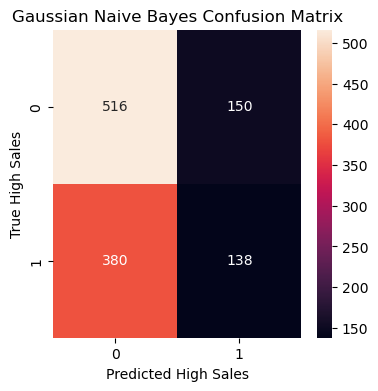

In [8665]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_nb, annot=True, fmt='.0f')
plt.xlabel("Predicted High Sales")
plt.ylabel("True High Sales")
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.show()

- True Negatives (TN): 516 weeks correctly predicted as low sales  
- False Positives (FP): 150 weeks incorrectly predicted as high sales  
- False Negatives (FN): 380 weeks incorrectly predicted as low sales  
- True Positives (TP): 138 weeks correctly predicted as high sales

The model is much more likely to correctly identify low sales weeks than high sales weeks, as seen by the high number of false negatives for the high sales class.

#### ROC Curve

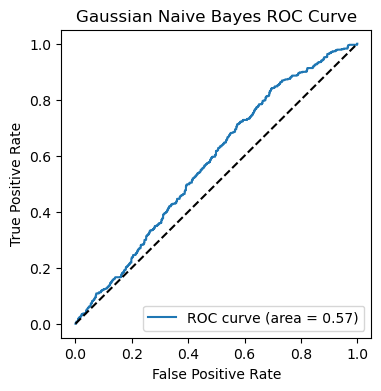

In [8666]:
y_proba_nb = bayes.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(4, 4))
plt.plot(fpr_nb, tpr_nb, label='ROC curve (area = {:.2f})'.format(roc_auc_nb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Naive Bayes ROC Curve')
plt.legend(loc="lower right")
plt.show()

The model’s ROC AUC is 0.57, only slightly better than random guessing, indicating poor ability to distinguish between high and low sales weeks.

#### Cross-Validation

In [8667]:
from sklearn.model_selection import cross_val_score

cv_scores_nb = cross_val_score(bayes, X, y, cv=5)
print("Cross-validation scores:", cv_scores_nb)
print("Mean CV accuracy: {:.2f}%".format(cv_scores_nb.mean() * 100))

Cross-validation scores: [0.5160473  0.46537162 0.55367709 0.534235   0.41335587]
Mean CV accuracy: 49.65%


Cross-validation scores range from about 41% to 55%, with a mean accuracy of 49.65%. This further suggests the model does not generalize well and is not effective for this classification task.

#### Feature Importance

Feature importance is not available for Gaussian Naive Bayes, as this model does not provide a direct measure of how much each feature contributes to predictions. Unlike tree-based models, Naive Bayes assumes all features contribute independently and equally based on their statistical distribution.

#### Train vs. Test Accuracy

In [8668]:
train_acc_nb = bayes.score(X_train, y_train)
test_acc_nb = bayes.score(X_test, y_test)
print(f"Train Accuracy: {train_acc_nb:.2f}")
print(f"Test Accuracy: {test_acc_nb:.2f}")

Train Accuracy: 0.56
Test Accuracy: 0.55


The model achieves 56% accuracy on the training set and 55% on the test set, indicating that it is not overfitting but also does not perform well on either set.

## Results & Discussion

**Model Performance Overview**

Three classification models—Decision Tree, Random Forest, and Gaussian Naive Bayes—were trained to predict whether a given week’s sales would be above or below average using general predictors (fuel price, CPI, unemployment, holiday flags, and temporal features). Performance was evaluated using accuracy, precision, recall, F1-score, ROC AUC, and cross-validation, providing a comprehensive view of each model’s strengths and weaknesses.

**Model Comparison Table**

| Model                  | Test Accuracy | ROC AUC | Precision (High Sales) | Recall (High Sales) | F1 (High Sales) | Mean CV Accuracy |
|------------------------|--------------|---------|-----------------------|---------------------|-----------------|------------------|
| Decision Tree          | 0.66         | 0.74    | 0.60                  | 0.67                | 0.63            | 0.23             |
| Random Forest          | 0.66         | 0.74    | 0.61                  | 0.60                | 0.60            | 0.28             |
| Gaussian Naive Bayes   | 0.55         | 0.57    | 0.48                  | 0.27                | 0.34            | 0.50             |

**Interpretation of Results**

- **Tree-based models (Decision Tree and Random Forest) outperformed Gaussian Naive Bayes** across almost all metrics. Both achieved 66% test accuracy and ROC AUC of 0.74, indicating a moderate ability to distinguish between high and low sales weeks. Their precision and recall scores for the high sales class were balanced, though slightly favoring the low sales class.  
- **Gaussian Naive Bayes performed notably worse**, with only 55% accuracy and an ROC AUC of 0.57, barely above random guessing. It struggled to identify high sales weeks (recall 0.27), indicating that the assumption of feature independence does not fit this dataset well.
- **Cross-validation scores were low and variable for all models**, especially for tree-based models, suggesting that model performance is unstable and may not generalize well to new data. This could be due to class imbalance, limited predictive power in the selected features, or data splits.
- **Feature importance analysis (for tree-based models) consistently highlighted unemployment, CPI, and temperature as the most influential predictors**, while temporal features and holiday flags contributed little. This suggests that economic indicators are more relevant than calendar-based or holiday effects for this prediction task.

**Key Insights and Surprising Findings**

- **No model achieved strong predictive power**: Even the best models only moderately exceeded random guessing, and cross-validation revealed instability. This suggests that general economic and temporal features alone are insufficient for reliably predicting above- or below-average sales at the aggregate level.
- **Imbalanced performance**: All models were better at identifying low sales weeks than high sales weeks, as shown by higher recall and precision for the low sales class. This is a common issue in imbalanced datasets and highlights the importance of using multiple metrics for evaluation.
- **Feature limitations**: The lack of strong predictors—especially the absence of store-specific or promotional data—likely limits the models’ effectiveness. The most important features (unemployment, CPI, temperature) only partially capture the complexity of sales dynamics.

**Summary**

- Tree-based models offered the best performance but still left substantial room for improvement.
- General economic and temporal features alone do not provide enough predictive power for this classification task.
- Incorporating additional data—such as store-specific factors or promotional information—and exploring more advanced modeling techniques would likely improve results.

## 8. Conclusion & Limitations

This analysis explored whether general economic and temporal features can predict if weekly Walmart sales are above or below average. Tree-based models (Decision Tree and Random Forest) offered the best performance, achieving around 66% accuracy and moderate ability to distinguish high from low sales weeks. However, all models—including Gaussian Naive Bayes—showed limited predictive power, with low and variable cross-validation scores.

Feature importance analysis revealed that unemployment, CPI, and temperature were the most influential predictors, while holiday and temporal features had little impact. Overall, the results suggest that general features alone are not sufficient for reliable sales classification.

Limitations of this study include the exclusion of store-specific and promotional data, potential class imbalance, and the limited scope of features. The weak correlations observed indicate that important drivers of sales may be missing from the dataset.

Future work should focus on incorporating richer data sources, such as store-level information, promotions, and local events, as well as exploring more advanced modeling techniques to improve predictive performance.

## Model Saving

To enable future use or deployment, we save all three trained models—Decision Tree, Random Forest, and Gaussian Naive Bayes to disk using `joblib`.

In [8670]:
import joblib

In [8671]:
# Save Decision Tree model
joblib.dump(decisionTreeClassifier, '../Data/DecisionTreeClassifier.pkl')

# Save Random Forest model
joblib.dump(randomForestClassifier, '../Data/RandomForestClassifier.pkl')

# Save Gaussian Naive Bayes model
joblib.dump(bayes, '../Data/GaussianNB.pkl')

['../Data/GaussianNB.pkl']

All trained models are now saved and can be easily loaded for further analysis or deployment.